In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2 as cv
from osgeo import gdal
import netCDF4
import tqdm
from scipy.spatial import ckdtree
plt.ion()
import xml.etree.ElementTree as ET
import scipy.io as io


In [2]:
# under WGS84 Assumption
# <semiMajorAxis units="m">6.378137000000000e+06</semiMajorAxis>
# <semiMinorAxis units="m">6.356752314245179e+06</semiMinorAxis>
# "a"
semiMajor = 6.378137000000000e+06
# "b"
semiMinor = 6.356752314245179e+06
#<slantRangeNearEdge units="m">8.436862401575363e+05</slantRangeNearEdge>
# "Rnear"
slant = 8.436862401575363e+05
groundOrigin = 0
def cart_transform(phi, lam):
    phi_rad = np.pi * phi/180
    lam_rad = np.pi * lam/180
    den = np.sqrt(semiMajor*semiMajor*np.cos(phi_rad)*np.cos(phi_rad) + semiMinor*semiMinor*np.sin(phi_rad)*np.sin(phi_rad))    
    Xuv = (semiMajor*semiMajor * np.cos(phi_rad) * np.cos(lam_rad))/den
    Yuv = (semiMajor*semiMajor * np.cos(phi_rad) * np.sin(lam_rad))/den
    Zuv = (semiMinor*semiMinor*np.sin(phi_rad))/den
    return (Xuv, Yuv, Zuv)

def cart_inv(x,y,z):
    phi_rad = np.arctan(semiMajor*z/(semiMinor*np.sqrt(semiMinor*semiMinor - z*z)))
    lam_rad = np.arctan2(y,x)
    phi = 180*phi_rad/(np.pi)
    lam = 180*lam_rad/(np.pi)
    return phi, lam

In [3]:
land_mask = io.loadmat('landmaskna.mat')

In [4]:
land_mask_val = land_mask['landnafp']

In [5]:
land_mask_flat_lat = land_mask['latvalsna'].flatten()

In [6]:
land_mask_flat_lon = land_mask['lonvalsna'].flatten()

In [7]:
land_lat_fit = np.poly1d(np.polyfit(land_mask_flat_lat,range(0, len(land_mask_flat_lat)), 1))

In [8]:
land_lon_fit = np.poly1d(np.polyfit(land_mask_flat_lon, range(0, len(land_mask_flat_lon)), 1))

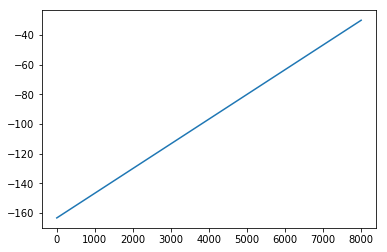

In [9]:
plt.plot(land_mask_flat_lon)

In [43]:
files = os.listdir('files_from_lynn/3frames_july2011/RS2_OK20392_PK226865_DK211169_SCWA_20110717_152007/')

In [44]:
tiff_path = r"C:\Users\clvco\URA_W18\files_from_lynn\RS2_OK16354_PK179351_DK169231_SCWA2_20101213_12002\RS2_OK16354_PK179351_DK169231_SCWA2_20101213_12002.tif"

In [45]:
# now we want to find the chart path
chart_path = os.path.join('training_data/charts/asi-n6250-20101213-v5.nc')

In [46]:
grid_path = os.path.join('training_data/LongitudeLatitudeGrid-n6250-Arctic.nc')

In [47]:
chart = netCDF4.Dataset(chart_path)

In [48]:
grid = netCDF4.Dataset(grid_path)

In [49]:
ice = np.asarray(chart.variables['ASI_Ice_Concentration'])

C:\Users\clvco\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: RuntimeWarning: invalid value encountered in less
  return array(a, dtype, copy=False, order=order)
C:\Users\clvco\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: RuntimeWarning: invalid value encountered in greater
  return array(a, dtype, copy=False, order=order)


In [50]:
chart_data_flat = np.asarray(chart.variables['ASI_Ice_Concentration']).flatten()

C:\Users\clvco\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: RuntimeWarning: invalid value encountered in less
  return array(a, dtype, copy=False, order=order)
C:\Users\clvco\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: RuntimeWarning: invalid value encountered in greater
  return array(a, dtype, copy=False, order=order)


In [51]:
latdata = np.asarray(grid.variables['Latitudes'])
londata = np.asarray(grid.variables['Longitudes'])

In [52]:
grid_lat_flat = np.asarray(grid.variables['Latitudes']).flatten()
grid_lon_flat = np.asarray(grid.variables['Longitudes']).flatten()
grid_flat = np.stack([grid_lat_flat, grid_lon_flat], 1)

In [53]:
chart_tree = ckdtree.cKDTree(grid_flat)

In [54]:
dataset = gdal.Open(tiff_path, gdal.GA_ReadOnly)

In [172]:
DOWNSAMPLE_RATE = 8
image = cv.imread(os.path.join(os.path.dirname(tiff_path), 'imagery_HH.tif'),0)
new_shape = (image.shape[1]//DOWNSAMPLE_RATE, image.shape[0]//DOWNSAMPLE_RATE) 
down_image = cv.resize(image, new_shape)

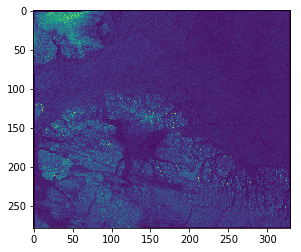

In [156]:
plt.imshow(down_image)

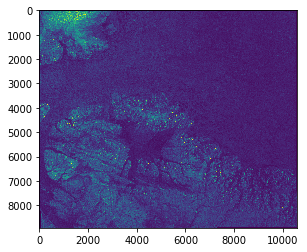

In [157]:
plt.imshow(image)

In [173]:
control_pts = dataset.GetGCPs()
control_pixel_locations = [(pt.GCPLine/DOWNSAMPLE_RATE, pt.GCPPixel/DOWNSAMPLE_RATE) for pt in control_pts]
control_tree = ckdtree.cKDTree(control_pixel_locations)

In [174]:
def idw(distances):
    if np.count_nonzero(distances) != len(distances):
        weights = np.zeros_like(distances)
        weights[0] = 1
    else:
        inverse_sum = sum([1/d for d in distances])
        weights = (1/distances)/inverse_sum
    return weights

In [175]:
def concentration(tree, lat, lon, samples=6):
    '''
    Given a lat-lon pair interpolate using IDW to find the actual concentration
    '''
    land_pos_y = int(np.round(land_lon_fit(lon-360)))
    land_pos_x = int(np.round(land_lat_fit(lat)))
    
    land_val = land_mask_val[land_pos_x,land_pos_y]
    
    if not np.isnan(land_val):
        return 255
    dists, idxs = tree.query((lat, lon), samples)
    concentration_values = np.array([chart_data_flat[i] for i in idxs])
    nan_vals = np.isnan(concentration_values)
    if any(nan_vals):
        return 255
    try:
        weights = idw(dists)
    except:
        weights = 1
        return chart_data_flat[idxs]
    return np.sum(np.multiply(concentration_values, weights))

In [176]:
SAMPLES = 4
pos_values = [cart_transform(pt.GCPY, pt.GCPX) for pt in control_pts]
concentration_image = np.zeros((down_image.shape[0:2]))
latlon_image = np.zeros([down_image.shape[0], down_image.shape[1], 2])
for i in range(latlon_image.shape[0]):
    for j in range(latlon_image.shape[1]):
        # put in max dist
        distances, indices = control_tree.query((i, j), SAMPLES)
        weights = idw(distances)
        X_values = [pos_values[index][0] for index in indices]
        Y_values = [pos_values[index][1] for index in indices]
        Z_values = [pos_values[index][2] for index in indices]
        X = np.sum(np.multiply(X_values, weights))
        Y = np.sum(np.multiply(Y_values, weights))
        Z = np.sum(np.multiply(Z_values, weights))
        lat, lon = cart_inv(X,Y,Z)
#         lon = np.sum(np.multiply([control_pts[index].GCPX for index in indices], weights))
#         lat = np.sum(np.multiply([control_pts[index].GCPY for index in indices], weights))
        conc = concentration(chart_tree, lat, 360+lon)
        concentration_image[i, j] = conc
        latlon_image[i,j,:] = [lat, lon]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1116/1116 [04:38<00:00,  4.00it/s]


In [100]:
lat, lon

(70.519959045432046, -72.539237392323273)

In [101]:
land_lat_fit(lat)

1168.6942348243265

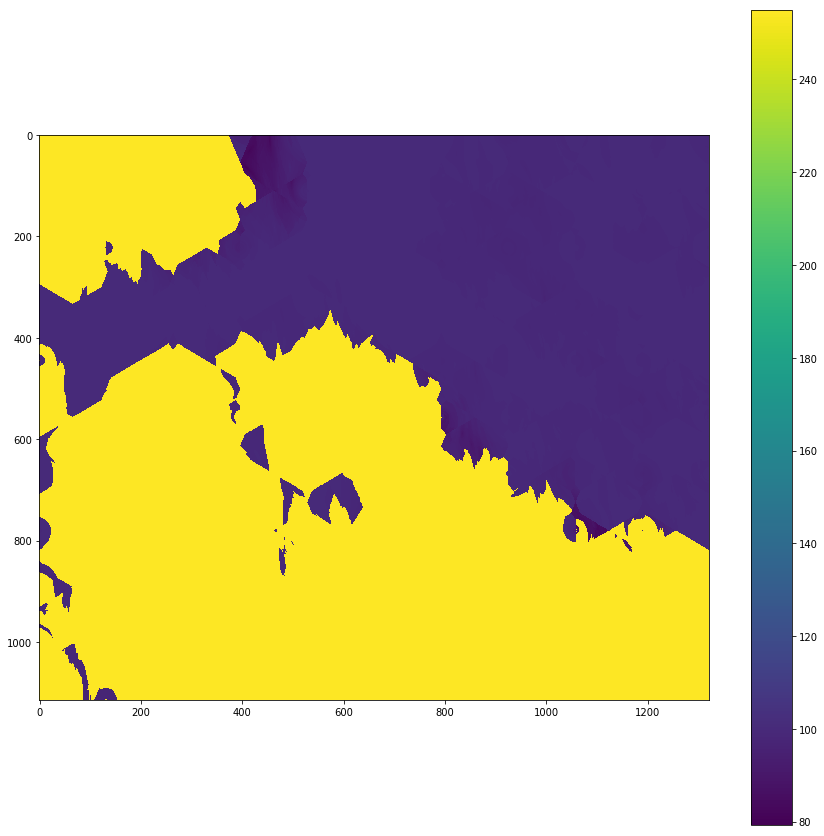

In [177]:
plt.figure(figsize=(15,15))
plt.imshow(concentration_image)
plt.colorbar()

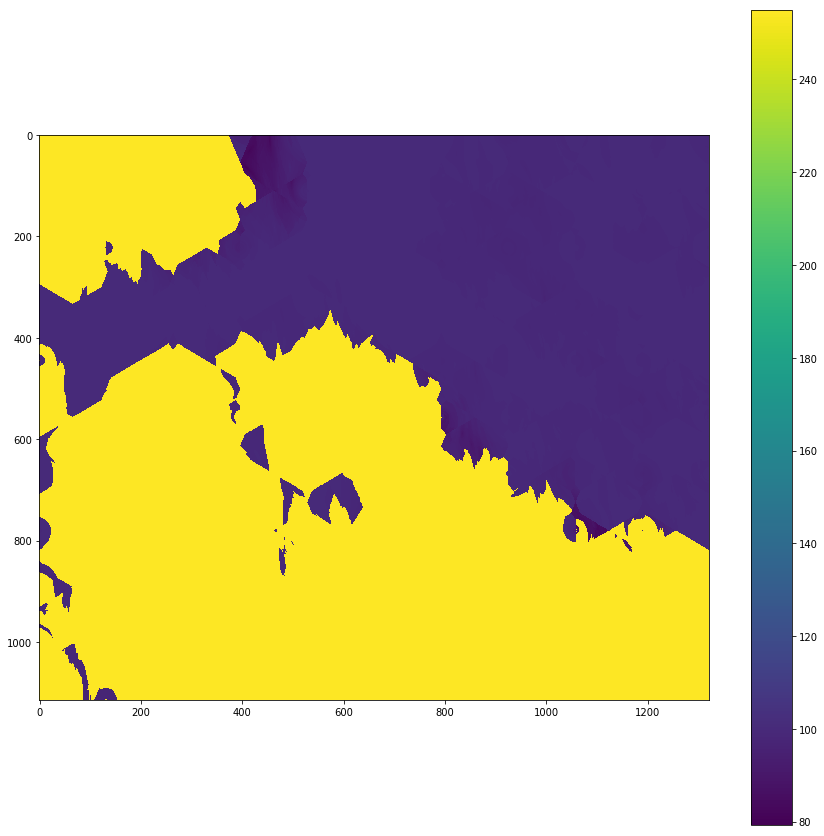

In [178]:
plt.figure(figsize=(15,15))
plt.imshow(concentration_image)
plt.colorbar()

In [179]:
cv.imwrite('conc.png', concentration_image)

True

In [180]:
cv.imwrite('img.png', down_image)

True

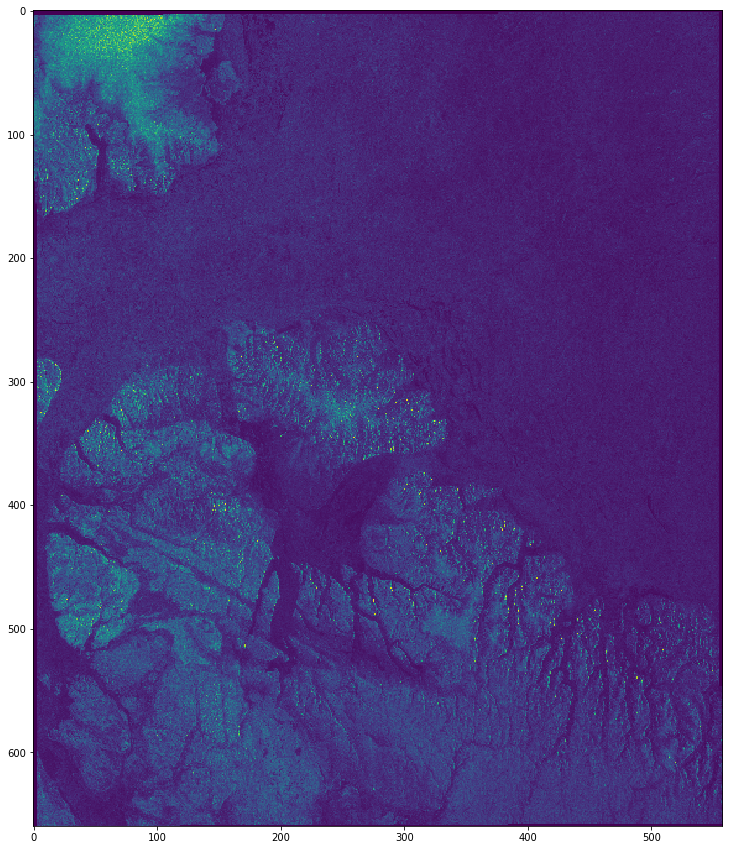

In [350]:
plt.figure(figsize=(15,15))
plt.imshow(down_image)

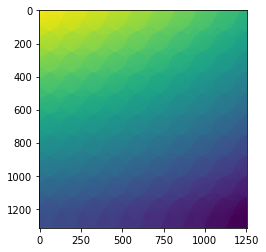

In [122]:
plt.imshow(latlon_image[:,:,0])

In [194]:
zer = np.zeros(ice.shape)

In [285]:
xs = [pt.GCPX for pt in control_pts]
ys = [pt.GCPY for pt in control_pts]


In [288]:
360 + min(xs)

273.4516421467208

In [320]:
thing = np.bitwise_and((latdata >= lat_min),(latdata <= lat_max))

In [321]:
thing2 = np.bitwise_and((londata >= 360+lon_min), (londata <= 360+lon_max))

In [198]:
180 - lon_min

266.545566675614

In [199]:
180 - lon_max

249.89792098604519

In [200]:
np.min(londata)

0.04782493

In [322]:
thing3 = np.bitwise_and(thing, thing2)

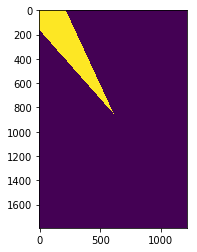

In [293]:
plt.imshow(thing2)

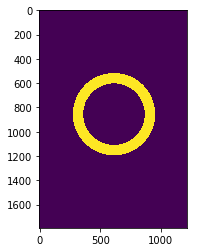

In [295]:
plt.imshow(thing)

In [339]:
rough_section = np.where(thing3,ice, zer)

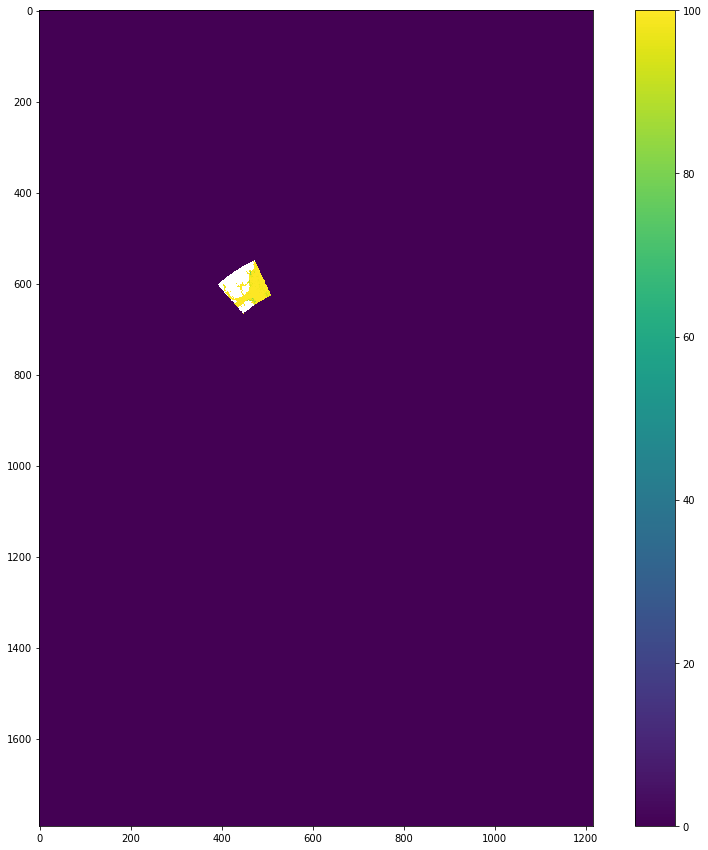

In [340]:
plt.figure(figsize=(15,15))
plt.imshow(rough_section)
plt.colorbar()

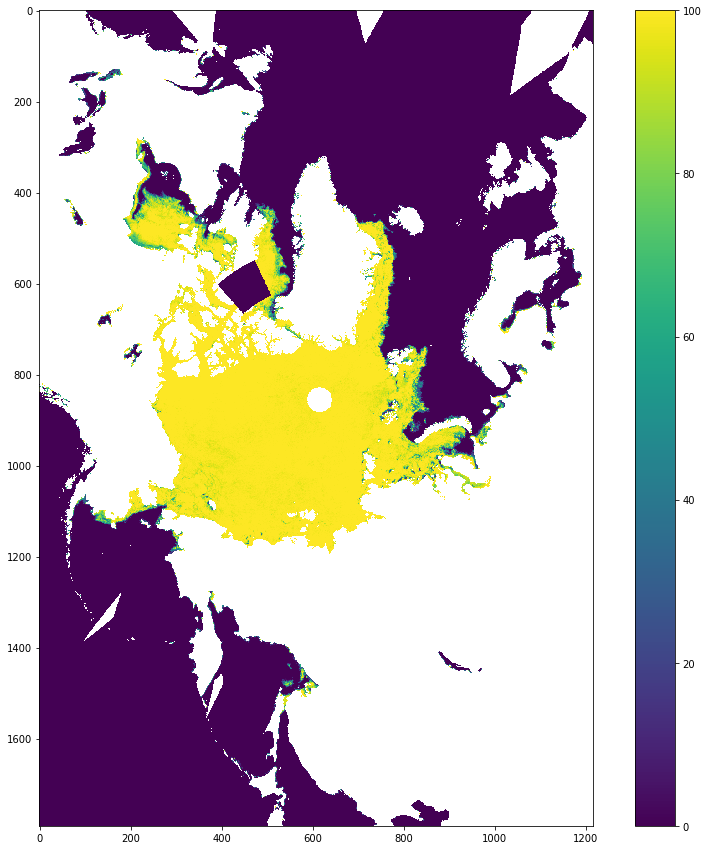

In [338]:
plt.figure(figsize=(15,15))
plt.imshow(rough_section)
plt.colorbar()

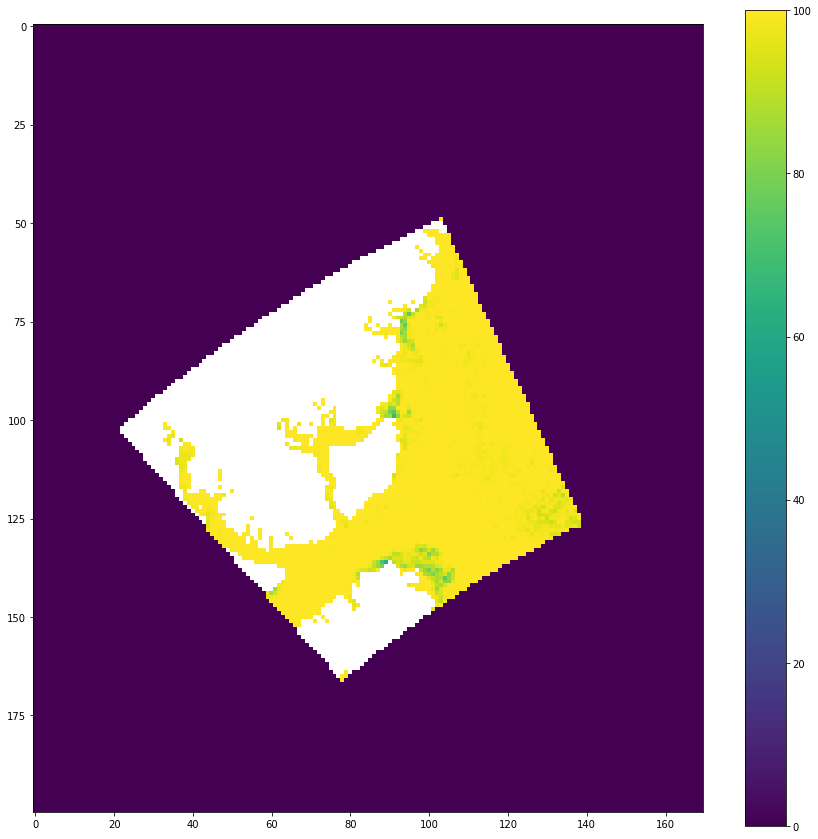

In [349]:
plt.figure(figsize=(15,15))
plt.imshow(rough_section[500:700,370:540])
plt.colorbar()

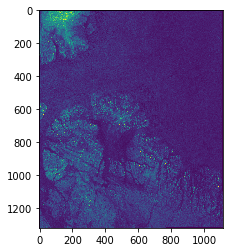

In [241]:
plt.imshow(down_image)

In [193]:
np.max(latlon_image[:,:,0])

75.506651751640419

In [319]:
lon_min = np.min(latlon_image[:,:,1])
lon_max = np.max(latlon_image[:,:,1])
lat_min = np.min(latlon_image[:,:,0])
lat_max = np.max(latlon_image[:,:,0])


In [125]:
np.max(latlon_image[:,:,1])

-103.98205435359475

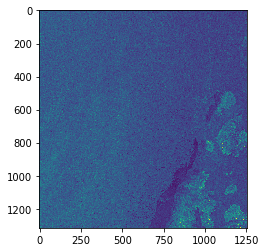

In [120]:
plt.imshow(down_image)

In [102]:
np.max(grid.variables['Longitudes'])

360.0

In [107]:
longitudes = np.asarray(grid.variables['Longitudes'])

In [108]:
neg_longitudes = longitudes-360

In [110]:
neg_longitudes.min()

-359.95218

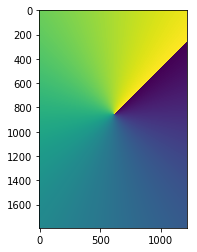

In [109]:
plt.imshow()

In [ ]:
np.where()

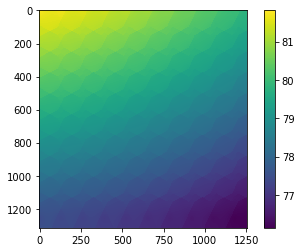

In [128]:
plt.imshow(latlon_image[:,:,0])
plt.colorbar()

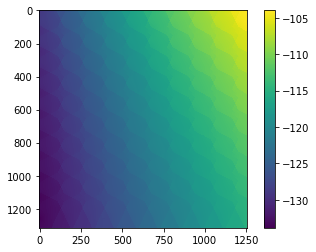

In [129]:
plt.imshow(latlon_image[:,:,1])
plt.colorbar()

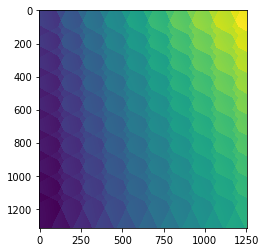

In [38]:
plt.imshow(latlon_image[:,:,0])

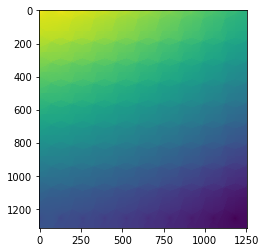

In [32]:
plt.imshow(latlon_image[:,:,1])

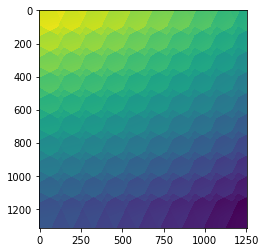

In [40]:
plt.imshow(latlon_image[:,:,1])